1. Instalação dos pacotes necessários

In [115]:
!pip install opencv-python numpy scipy

2. Inicialização dos módulos

In [116]:
from os.path import join, isfile, abspath
from os import listdir
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import tstd, norm

3. Inicialização de constantes e carregamento de arquivos

In [117]:
folderName = 'Vistex'                               # Nome da pasta
absFolderName = join(abspath('./'), folderName)     # Caminho absoluto da pasta de referência

In [118]:
N = 2                                                                                   # Número máximo de imagens de saída
img_ref_name = 'c005_006.png'                                                           # Imagem de entrada para a rede
filesInFolder = [f for f in listdir(absFolderName) if isfile(join(absFolderName, f))]   # Obtém todas as imagens na pasta
filesInFolder.remove(img_ref_name)                                                      # Remove a imagem de referência da lista

In [119]:
color = ('b','g','r')   # Define a gama de cores padrão OpenCV
channels = len(color)   # Define a quantidade de canais
K = len(filesInFolder)  # Numero total de arquivos de imagens

4. Carregamento da imagem de entrada

In [120]:
# Inicialização de variáveis e abertura da imagem
img_ref = cv.imread(join(absFolderName, img_ref_name), flags=cv.IMREAD_COLOR)
BGR_std_img_ref = np.zeros(channels, dtype=np.float16)

for j in range(channels):
    histBGR = np.histogram(img_ref[:,:,j], bins=256)[0]     # Calcula histograma
    BGR_std_img_ref[j] = tstd(histBGR)                      # Desvio Padrão

5. Calcula do Desvio Padrão de cada uma das imagens na pasta para cada canal RGB

In [121]:
BGR_std_img_aux = np.zeros([K, channels], dtype=np.float16)

for i, img_name in enumerate(filesInFolder):
    
    img_aux = cv.imread(join(absFolderName, img_name), flags=cv.IMREAD_COLOR)
    
    for j in range(channels):
        histBGR = np.histogram(img_aux[:,:,j], bins=256)[0]
        BGR_std_img_aux[i, j] = tstd(histBGR)

Para comparar as imagens, podemos descrever a função de intersecção entre PDFs, na qual comparamos uma imagem na pasta e a imagem de referência. As `N` amostras de imagens que conterem a maior área de intersecção das PDFs, são consideradas as mais semelhantes, em ordem decrescente.

<img src="./intersection_PDF.png" alt="Intersecção de PDF's" style="width:400px;"/>

A intersecção desta área para 3 canais de cores (RGB) é definida pela função

$\int_{-\infty}^{\infty} min(f_0(t),f_i(t)) \,dt$

onde $f_0(t)$ é a PDF da imagem de entrada e $f_i(t)$ é a PDF de cada imagem da pasta com $1<=i<=K$, sendo `K` o número de imagens para comparação.
Além disso, como todas as imagens da pasta são matrizes quadradas de 128x128 pixels, a média do histograma para cada canal RGB será fixo em $\frac{128}{2}=64$

6. Calcula o ponto de intersecção `p0` das PDFs

In [122]:
# Calcula as raízes da intersecção de duas curvas normais Gaussianas
def normal_intersection(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

7. Calcula a área relativa à intersecção da PDF para cada canal RGB através da CDF

In [123]:
mean = 64                                               # Média estática para o histograma dos canais RGB
IArea = np.zeros([K, channels], dtype=np.float32)       # Área de intersecção entre a imagem de referência e a auxiliar

for i in range(K):
    for j in range(channels):
        p0 = normal_intersection(mean, mean, BGR_std_img_ref[j], BGR_std_img_aux[i,j])
        if len(p0) == 2:
            if BGR_std_img_aux[i,j] > BGR_std_img_ref[j]:
                IArea[i, j] = 1 + norm.cdf(p0[0], mean, BGR_std_img_aux[i,j]) - norm.cdf(p0[1], mean, BGR_std_img_aux[i,j]) - norm.cdf(p0[0], mean, BGR_std_img_ref[j]) + norm.cdf(p0[1], mean, BGR_std_img_ref[j])
            else:
                IArea[i, j] = 1 + norm.cdf(p0[0], mean, BGR_std_img_ref[j]) - norm.cdf(p0[1], mean, BGR_std_img_ref[j]) - norm.cdf(p0[0], mean, BGR_std_img_aux[i,j]) + norm.cdf(p0[1], mean, BGR_std_img_aux[i,j])
        else:
            IArea[i, j] = 0
            print(f'{i} {len(p0)}')

8. Encontra os `N` valores máximos de área de intersecção entre as PDFs

In [124]:
IAreaNormalized = np.linalg.norm(IArea,axis=1)      # Obtém a norma do vetor de área
aux = np.zeros([K, 2], dtype=IAreaNormalized.dtype) # Cria um vetor auxiliar ordenado decrescentemente para as N maiores áreas de intersecção
aux[:,0] = np.arange(K)
aux[:,1] = IAreaNormalized
aux = aux[aux[:,1].argsort()[::-1]]

In [125]:
result = list()     # Obtém os N nome de arquivos respectivos às maiores áreas de intersecção
for i in range(N):
    result.append(filesInFolder[np.uint(aux[i,0])])

9. Plota as `N` imagens mais semelhantes

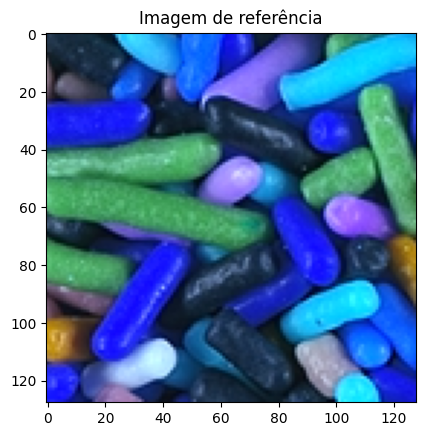

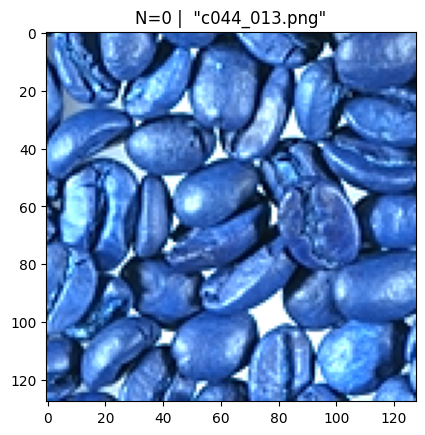

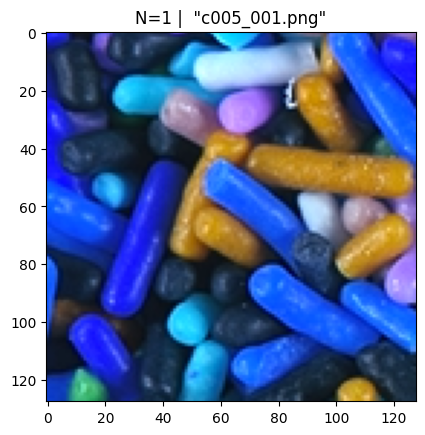

In [134]:
plt.imshow(img_ref)
plt.title('Imagem de referência')
plt.show()
for i in range(N):
    img_aux = cv.imread(join(absFolderName, filesInFolder[np.uint(aux[i,0])]), flags=cv.IMREAD_COLOR)
    plt.imshow(img_aux)
    plt.title(f'N={i} |  "{filesInFolder[np.uint(aux[i,0])]}"')
    plt.show()